#Task 1

In [1]:
# Install and authenticate Earth Engine
!pip install earthengine-api folium geemap pgmpy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [2]:
import ee
import geemap
from IPython.display import Image
import matplotlib.pyplot as plt

In [3]:
# ---- INITIALIZE EARTH ENGINE ----
try:
    ee.Initialize(project='pgm-hw3')
except Exception as e:
    print("Authenticating Earth Engine...")
    ee.Authenticate()
    ee.Initialize(project='pgm-hw3')

Authenticating Earth Engine...


In [4]:
# ---- DEFINE LOCATION & REGION ----
longitude = -73.9632  # Metropolitan Museum of Art, NYC
latitude = 40.7794
buffer_radius_m = 304.8  # 1000 ft ≈ 304.8 meters

In [5]:
# Define center point and precise circular region
point = ee.Geometry.Point([longitude, latitude])
roi = point.buffer(buffer_radius_m)  # Circular buffer for 1000 ft radius

In [6]:
# ---- LOAD HIGH-RES NAIP IMAGE ----
naip_collection = (ee.ImageCollection("USDA/NAIP/DOQQ")
                   .filterBounds(roi)
                   .filterDate("2020-01-01", "2023-12-31"))

In [7]:
# Check if NAIP imagery is available
image_count = naip_collection.size().getInfo()
if image_count == 0:
    print("No NAIP imagery available for the specified region and date range.")
    print("Falling back to Sentinel-2...")
    image = (ee.ImageCollection('COPERNICUS/S2_SR')
             .filterBounds(roi)
             .filterDate('2020-01-01', '2023-12-31')
             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
             .sort('CLOUDY_PIXEL_PERCENTAGE')
             .first()
             .clip(roi)  # Clip to exact circular radius
             .select(['B4', 'B3', 'B2']))
else:
    image = (naip_collection
             .mosaic()
             .clip(roi)  # Clip to exact circular radius
             .select(['R', 'G', 'B']))

In [8]:
# ---- CREATE AND DISPLAY MAP ----
Map = geemap.Map(center=[latitude, longitude], zoom=15)
Map.addLayer(image, {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 255}, 'Satellite Imagery')

In [9]:
# Add circular selection with transparent fill and red outline
Map.addLayer(roi, {'color': 'red', 'fillColor': 'FF000055'}, '1000 ft Circular Selection')  # Semi-transparent red fill
Map.centerObject(roi, 16)  # Center map on ROI with zoom level 16
display(Map)

Map(center=[40.779400312696694, -73.96319998852768], controls=(WidgetControl(options=['position', 'transparent…

In [10]:
# ---- GENERATE THUMBNAIL URL ----
thumb_params = {
    'dimensions': '350x350',
    'region': roi,  # Use circular ROI for thumbnail
    'format': 'png',
    'min': 0,
    'max': 255
}
try:
    thumbnail_url = image.getThumbURL(thumb_params)
    print("Thumbnail URL:", thumbnail_url)
except Exception as e:
    print("Error generating thumbnail:", e)
    raise e

Thumbnail URL: https://earthengine.googleapis.com/v1/projects/pgm-hw3/thumbnails/69b7b3d672d1de0e68210b218e451e69-ef8d2862f74e4d669d9a5a5375be4507:getPixels


In [11]:
# ---- DOWNLOAD IMAGE ----
from requests import get
response = get(thumbnail_url)
if response.status_code == 200:
    from PIL import Image as PILImage
    from io import BytesIO
    img = PILImage.open(BytesIO(response.content))
    img = img.convert('RGB')  # Ensure RGB format
    img.save("satellite_image.png")
    print("Saved: satellite_image.png")
else:
    print("Failed to download image. Status code:", response.status_code)
    raise Exception("Image download failed")

Saved: satellite_image.png


In [12]:
# ---- SHARPEN IMAGE USING OPENCV ----
import cv2
import numpy as np
input_img = cv2.imread('satellite_image.png')
kernel = np.array([[0, -1, 0],
                   [-1, 5, -1],
                   [0, -1, 0]])
sharpened_img = cv2.filter2D(input_img, -1, kernel)
cv2.imwrite('sharpened_image.png', sharpened_img)
print("Saved: sharpened_image.png")

Saved: sharpened_image.png


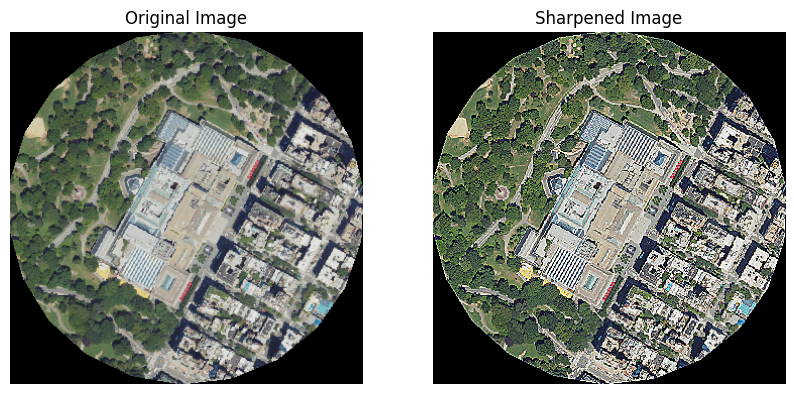

In [13]:
# ---- DISPLAY IMAGES ----
original = PILImage.open("satellite_image.png")
sharpened = PILImage.open("sharpened_image.png")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sharpened)
plt.title("Sharpened Image")
plt.axis('off')

plt.show()

#Task 2

In [14]:
# ---- LOAD ELEVATION DATA ----
elevation = ee.Image('USGS/SRTMGL1_003').clip(roi)  # NASA SRTM 30m resolution

# Calculate mean elevation
mean_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=30  # SRTM resolution
).get('elevation').getInfo()

print(f"Mean Elevation within 1000 ft radius: {mean_elevation:.2f} meters")

# ---- CREATE AND DISPLAY MAP ----
Map = geemap.Map(center=[latitude, longitude], zoom=15)
Map.addLayer(image, {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 255}, 'Satellite Imagery')
# Add elevation layer with refined color palette and range
Map.addLayer(elevation, {'min': 0, 'max': 50, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Elevation')
Map.addLayer(roi, {'color': 'red', 'fillColor': 'FF000055'}, '1000 ft Circular Selection')  # Semi-transparent red fill
# Add elevation legend
vis_params = {'min': 0, 'max': 50, 'palette': ['blue', 'green', 'yellow', 'red']}
Map.add_colorbar(vis_params, label="Elevation (meters)")
Map.centerObject(roi, 16)  # Center map on ROI with zoom level 16
display(Map)

Mean Elevation within 1000 ft radius: 39.59 meters


Map(center=[40.779400312696694, -73.96319998852768], controls=(WidgetControl(options=['position', 'transparent…

In [15]:
# ---- RETRIEVE ELEVATION USING SRTM ----
elevation = ee.Image('USGS/SRTMGL1_003').clip(roi)  # NASA SRTM 30m resolution

# Get elevation at the specified point
elevation_point = elevation.reduceRegion(
    reducer=ee.Reducer.first(),
    geometry=point,
    scale=30  # SRTM resolution
).get('elevation').getInfo()

print(f"Elevation at {latitude}, {longitude}: {elevation_point:.2f} meters")

# ---- CREATE AND DISPLAY MAP ----
Map = geemap.Map(center=[latitude, longitude], zoom=15)
Map.addLayer(image, {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 255}, 'Satellite Imagery')
# Add elevation layer with refined color palette and range
Map.addLayer(elevation, {'min': 0, 'max': 50, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Elevation')
Map.addLayer(roi, {'color': 'red', 'fillColor': 'FF000055'}, '1000 ft Circular Selection')  # Semi-transparent red fill
# Add pointer at the specified point
Map.addLayer(ee.Geometry.Point([longitude, latitude]), {'color': 'yellow', 'pointSize': 5}, 'Selected Point')
# Add elevation value as a popup
elevation_label = f"Elevation: {elevation_point:.2f} meters"
Map.addLayerControl()
Map.centerObject(roi, 16)  # Center map on ROI with zoom level 16
# Use a hack to add a popup (geemap limitation workaround)
Map.js_snippet = f"""
L.marker([{latitude}, {longitude}]).addTo(Map).bindPopup("{elevation_label}").openPopup();
"""
display(Map)

Elevation at 40.7794, -73.9632: 46.00 meters


Map(center=[40.779400312696694, -73.96319998852768], controls=(WidgetControl(options=['position', 'transparent…

#Task 3

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import rgb2gray
from scipy.ndimage import generic_filter

In [17]:
# Step 1: Preprocess the Satellite Image
img = cv2.imread('sharpened_image.png')
if img.shape[:2] != (350, 350):
    img = cv2.resize(img, (350, 350), interpolation=cv2.INTER_LINEAR)
    cv2.imwrite('resized_image.png', img)
    print("Image resized to 350x350 pixels and saved as resized_image.png")
else:
    print("Image is already 350x350 pixels")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_normalized = img_rgb / 255.0

Image is already 350x350 pixels


In [18]:
# Step 2: Generate Superpixels
segments = slic(img_normalized, n_segments=400, compactness=10, sigma=1, start_label=0)
num_segments = len(np.unique(segments))

In [19]:
# Step 3: Compute Features for Each Superpixel and Intensity Differences
def variance_filter(arr):
    return np.var(arr)

# Convert to grayscale for texture and intensity differences
img_gray = rgb2gray(img_normalized)
texture = generic_filter(img_gray, variance_filter, size=3, mode='constant')

# Compute intensity differences between adjacent pixels
diffs = []
for i in range(img_gray.shape[0] - 1):
    for j in range(img_gray.shape[1] - 1):
        diff_horizontal = abs(img_gray[i, j] - img_gray[i, j + 1])
        diff_vertical = abs(img_gray[i, j] - img_gray[i + 1, j])
        diffs.extend([diff_horizontal, diff_vertical])

# Average color and texture per superpixel
segment_means = np.zeros((num_segments, 3))
segment_textures = np.zeros(num_segments)
for seg_id in range(num_segments):
    mask = (segments == seg_id)
    segment_means[seg_id] = np.mean(img_normalized[mask], axis=0)
    segment_textures[seg_id] = np.mean(texture[mask])

In [20]:
# Step 4: Tune Thresholds with Histogram Analysis
green_channel = img_normalized[:, :, 1].flatten()
green_hist, bins = np.histogram(green_channel, bins=50, range=(0, 1))
threshold_green = bins[np.argmax(green_hist[green_hist > np.mean(green_hist)])]  # Peak above mean
threshold_texture = np.percentile(segment_textures, 75)  # 75th percentile for high texture

# Print sample features for manual tuning
print("Sample Superpixel Features (Mean RGB, Texture):")
for i in range(min(5, num_segments)):
    print(f"Segment {i}: {segment_means[i]}, Texture: {segment_textures[i]}")

Sample Superpixel Features (Mean RGB, Texture):
Segment 0: [0. 0. 0.], Texture: 0.0
Segment 1: [0. 0. 0.], Texture: 0.0
Segment 2: [0. 0. 0.], Texture: 0.0
Segment 3: [0. 0. 0.], Texture: 0.0
Segment 4: [0.01087211 0.01146474 0.01286948], Texture: 0.006630576804262844


In [21]:
# Step 5: Rule-Based Labeling
segment_labels = np.zeros(num_segments, dtype=np.uint8)
for seg_id in range(num_segments):
    mean_color = segment_means[seg_id]
    texture_val = segment_textures[seg_id]

    # Tuned thresholds based on histogram and texture
    is_vegetation = mean_color[1] > threshold_green and mean_color[0] < 0.4 and mean_color[2] < 0.4  # High G, moderate R/B
    is_grass = is_vegetation and texture_val < threshold_texture / 2  # Low texture for grass
    is_forest = is_vegetation and not is_grass and texture_val < threshold_texture  # Higher texture for forest
    is_other = not is_vegetation or texture_val > threshold_texture  # Urban or high texture

    if is_forest:
        segment_labels[seg_id] = 0  # Forest
    elif is_grass:
        segment_labels[seg_id] = 1  # Grass
    else:
        segment_labels[seg_id] = 2  # Other

# Map labels to full image
segmentation_full = np.zeros_like(segments, dtype=np.uint8)
for seg_id in range(num_segments):
    segmentation_full[segments == seg_id] = segment_labels[seg_id]

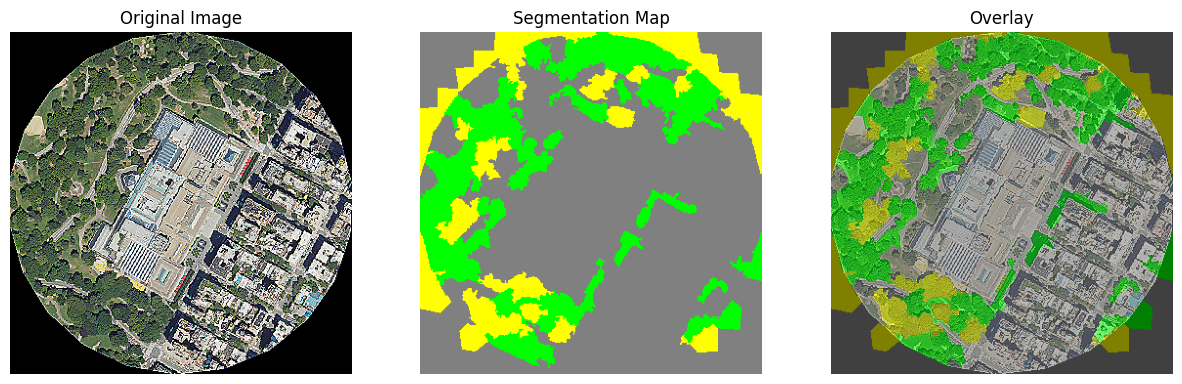

In [22]:
# Step 6: Visualize Results
color_map = {
    0: [0, 255, 0],    # Green for forest
    1: [255, 255, 0],  # Yellow for grass
    2: [128, 128, 128] # Gray for other
}

seg_vis = np.zeros_like(img_rgb)
for label in range(3):
    seg_vis[segmentation_full == label] = color_map[label]

alpha = 0.5
overlay = (alpha * seg_vis + (1 - alpha) * img_rgb).astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(seg_vis)
plt.title("Segmentation Map")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis('off')
plt.show()

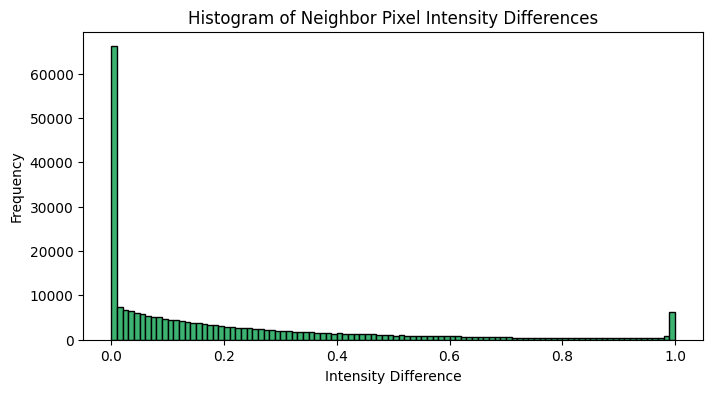

In [23]:
# Step 7: Plot Histogram of Intensity Differences
plt.figure(figsize=(8, 4))
plt.hist(diffs, bins=100, color='mediumseagreen', edgecolor='black')
plt.title("Histogram of Neighbor Pixel Intensity Differences")
plt.xlabel("Intensity Difference")
plt.ylabel("Frequency")
plt.show()

In [24]:
# Step 8: Save Results
cv2.imwrite('segmentation_map.png', cv2.cvtColor(seg_vis, cv2.COLOR_BGR2RGB))
cv2.imwrite('segmentation_overlay.png', cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
print("Saved: segmentation_map.png, segmentation_overlay.png")

Saved: segmentation_map.png, segmentation_overlay.png


#Task 4

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load segmentation map and original image
seg_map = cv2.imread('segmentation_map.png')
orig_img = cv2.imread('sharpened_image.png')

# Convert to RGB for consistency
seg_map_rgb = cv2.cvtColor(seg_map, cv2.COLOR_BGR2RGB)
orig_img_rgb = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# Verify dimensions (should be 350x350)
assert seg_map_rgb.shape[:2] == (350, 350), "Segmentation map must be 350x350"
assert orig_img_rgb.shape[:2] == (350, 350), "Original image must be 350x350"

In [26]:
# Create a boundary mask by detecting RGB differences
boundary_mask = np.zeros((350, 350), dtype=np.uint8)
for i in range(350):
    for j in range(350):
        if i < 349 or j < 349:  # Avoid out-of-bounds
            current = seg_map_rgb[i, j]
            # Check right and bottom neighbors
            if j < 349:
                right = seg_map_rgb[i, j + 1]
                if not np.array_equal(current, right):
                    boundary_mask[i, j] = 255
            if i < 349:
                down = seg_map_rgb[i + 1, j]
                if not np.array_equal(current, down):
                    boundary_mask[i, j] = 255

# Dilate boundaries for visibility
kernel = np.ones((3, 3), np.uint8)
boundary_mask_dilated = cv2.dilate(boundary_mask, kernel, iterations=1)

In [27]:
# Create a boundary image with the same size as the original
boundary_img = np.zeros_like(orig_img_rgb)

# Assign colors to boundaries based on adjacent regions
color_map = {
    0: [0, 255, 0],    # Green for forest
    1: [255, 255, 0],  # Yellow for grass
    2: [128, 128, 128] # Gray for other
}

def get_dominant_label(i, j):
    neighbors = []
    for di in [-1, 0, 1]:
        for dj in [-1, 0, 1]:
            if 0 <= i + di < 350 and 0 <= j + dj < 350 and (di != 0 or dj != 0):
                # Approximate label from RGB (green: ~[0,255,0], yellow: ~[255,255,0], gray: ~[128,128,128])
                pixel = seg_map_rgb[i + di, j + dj]
                if np.allclose(pixel, color_map[0], atol=10):
                    neighbors.append(0)
                elif np.allclose(pixel, color_map[1], atol=10):
                    neighbors.append(1)
                elif np.allclose(pixel, color_map[2], atol=10):
                    neighbors.append(2)
    return max(set(neighbors), key=neighbors.count) if neighbors else 2

for i in range(350):
    for j in range(350):
        if boundary_mask_dilated[i, j] > 0:
            dominant_label = get_dominant_label(i, j)
            boundary_img[i, j] = color_map[dominant_label]

In [28]:
# Create overlay with boundaries
alpha = 0.7  # Adjust transparency
overlay = orig_img_rgb.copy()
overlay[boundary_mask_dilated > 0] = (1 - alpha) * overlay[boundary_mask_dilated > 0] + alpha * boundary_img[boundary_mask_dilated > 0]
overlay = overlay.astype(np.uint8)

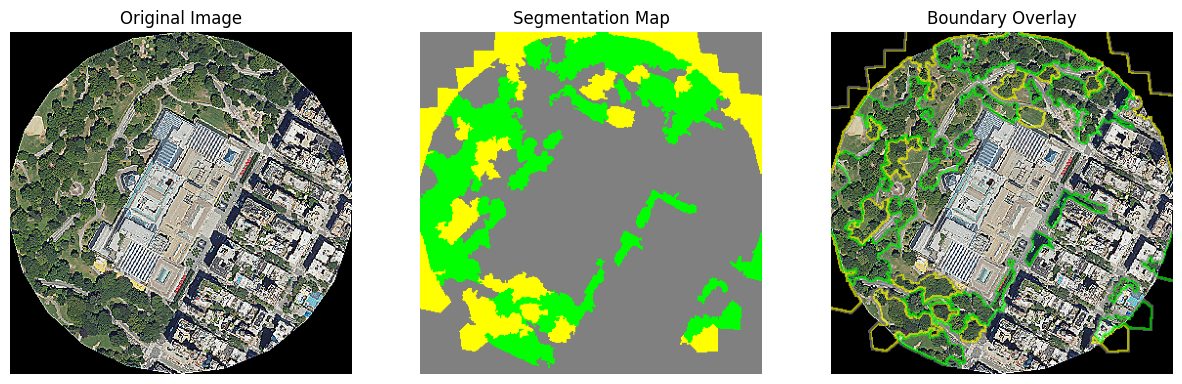

Saved: boundaries_overlay.png


In [29]:
# Visualize results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(orig_img_rgb)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(seg_map_rgb)
plt.title("Segmentation Map")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Boundary Overlay")
plt.axis('off')
plt.show()

# Save the boundary overlay
cv2.imwrite('boundaries_overlay.png', cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
print("Saved: boundaries_overlay.png")

#Task 3

Cluster 0: Hue=1.8, Saturation=1.4, Value=3.1
Cluster 1: Hue=79.3, Saturation=136.3, Value=85.7
Cluster 2: Hue=38.6, Saturation=36.1, Value=207.8


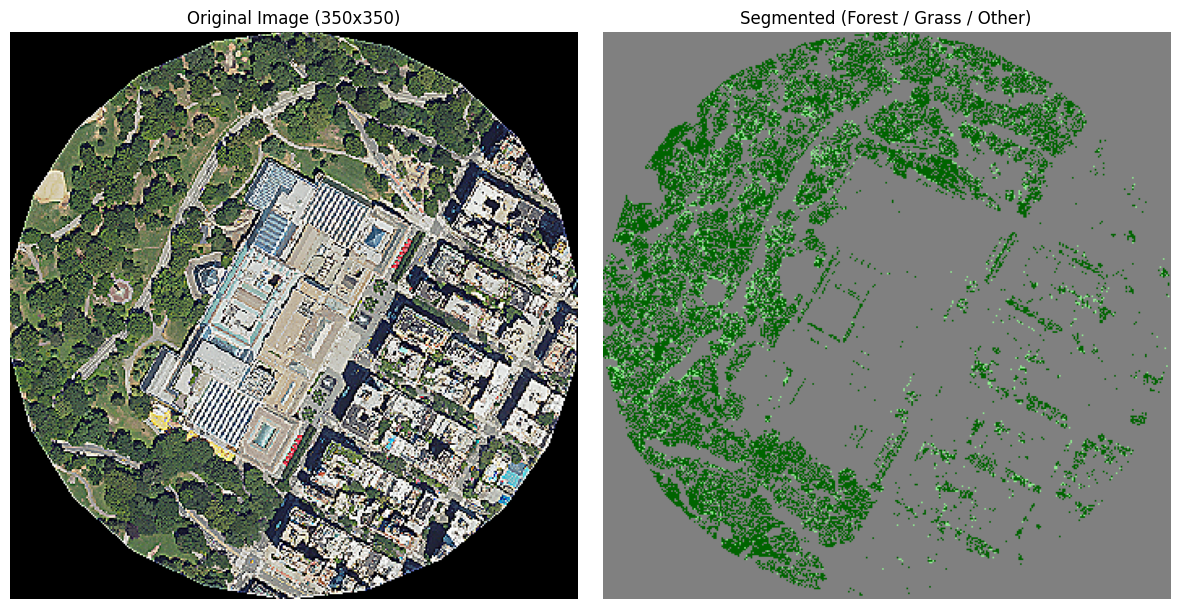

In [30]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Step 1: Load and resize image
img = cv2.imread("sharpened_image.png")  # Use your downloaded image
resized_img = cv2.resize(img, (350, 350))  # Consistent resolution
cv2.imwrite("image_350x350.png", resized_img)

# Step 2: Convert to HSV
hsv_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2HSV)
hsv_pixels = hsv_img.reshape(-1, 3)

# Step 3: KMeans clustering (3 classes: forest, grass, other)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10) # Add n_init for KMeans
kmeans_labels = kmeans.fit_predict(hsv_pixels)

# Reshape kmeans_labels to match image dimensions
kmeans_labels_reshaped = kmeans_labels.reshape(resized_img.shape[:2])


# Step 4: Analyze cluster centers to label forest/grass/other
cluster_centers = kmeans.cluster_centers_  # HSV centers
for i, center in enumerate(cluster_centers):
    h, s, v = center
    print(f"Cluster {i}: Hue={h:.1f}, Saturation={s:.1f}, Value={v:.1f}")

# Step 5: Determine class based on Hue (green ~ [35–90])
# Sort clusters by hue (descending green-ness)
hue_values = [center[0] for center in cluster_centers]
sorted_indices = np.argsort(hue_values)[::-1]

# Map cluster index to class name
label_map = {}
label_map[sorted_indices[0]] = "Forest"
label_map[sorted_indices[1]] = "Grass"
label_map[sorted_indices[2]] = "Other"

# Step 6: Create segmented image with improved rules
segmented_img = np.zeros_like(resized_img)

color_palette = {
    "Forest": (0, 100, 0),
    "Grass": (144, 238, 144),
    "Other": (128, 128, 128)
}

for i in range(resized_img.shape[0]):
    for j in range(resized_img.shape[1]):
        cluster_idx = kmeans_labels_reshaped[i, j] # Use kmeans_labels_reshaped
        class_name = label_map[cluster_idx]
        hue, sat, val = hsv_img[i, j]

        # Reassign based on actual HSV thresholds
        if 35 <= hue <= 90 and sat >= 60 and val >= 60:
            # It's green, now check brightness and saturation
            if val >= 100 and sat >= 140:
                class_name = "Grass"  # Brighter green → likely grass
            else:
                class_name = "Forest"  # Darker or denser → likely forest
        else:
            class_name = "Other"  # Not green enough

        segmented_img[i, j] = color_palette[class_name]



# Step 7: Visualize results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image (350x350)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(segmented_img, cv2.COLOR_BGR2RGB))
plt.title("Segmented (Forest / Grass / Other)")
plt.axis('off')

plt.tight_layout()
plt.show()

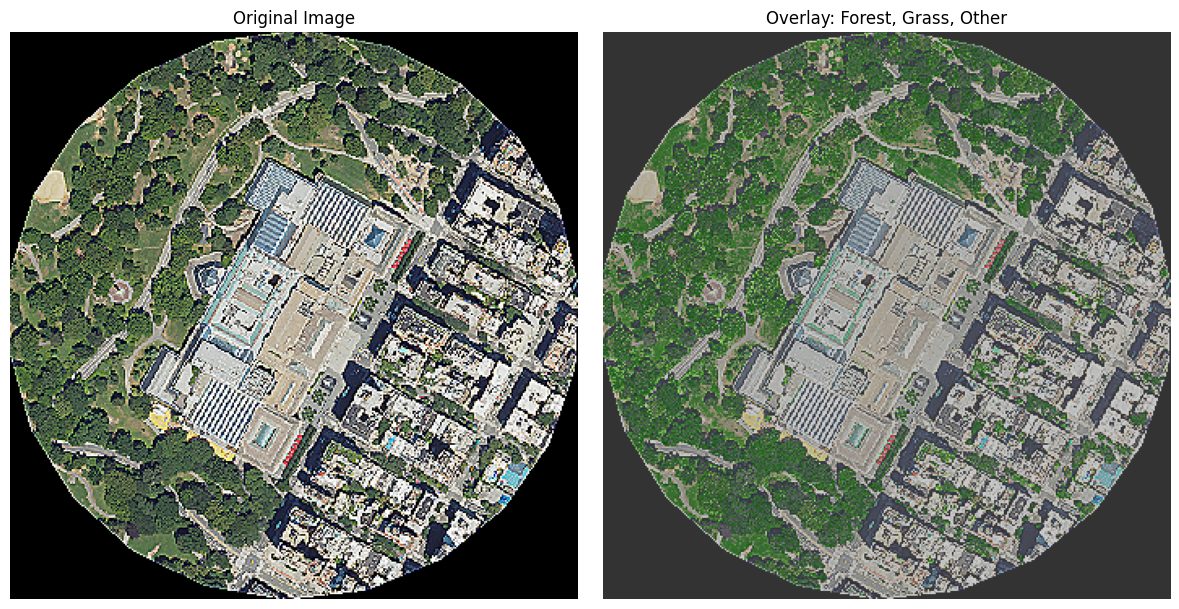

In [31]:
import seaborn as sns
from collections import Counter

# Map class names to colors again
class_colors_bgr = {
    "Forest": (0, 100, 0),
    "Grass": (144, 238, 144),
    "Other": (128, 128, 128)
}

# Step 1: Create a mask for each class
segmentation_map = np.zeros_like(segmented_img[:, :, 0], dtype=object)

for i in range(segmented_img.shape[0]):
    for j in range(segmented_img.shape[1]):
        color = tuple(segmented_img[i, j])
        if np.array_equal(color, color_palette["Forest"]):
            segmentation_map[i, j] = "Forest"
        elif np.array_equal(color, color_palette["Grass"]):
            segmentation_map[i, j] = "Grass"
        else:
            segmentation_map[i, j] = "Other"

# Step 2: Create overlays
overlay = resized_img.copy()

# Add semi-transparent overlay per class
alpha = 0.4
for class_name, bgr_color in class_colors_bgr.items():
    mask = (segmentation_map == class_name)
    # Create a color array with the same shape as the masked region
    color_overlay = np.full(resized_img[mask].shape, bgr_color, dtype=np.uint8)
    overlay[mask] = cv2.addWeighted(resized_img[mask], 1 - alpha, color_overlay, alpha, 0)

# Step 3: Plot overlay and original side-by-side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlay: Forest, Grass, Other")
plt.axis('off')

plt.tight_layout()
plt.show()

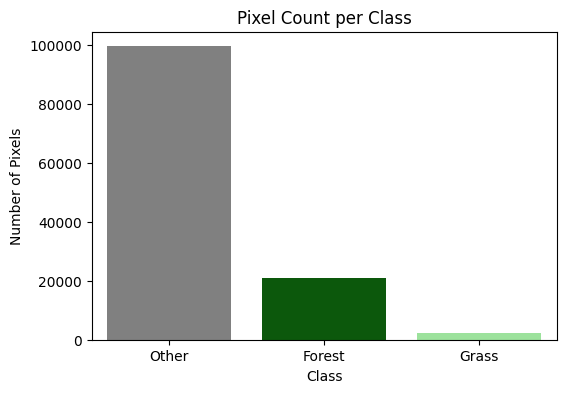

In [32]:
# Count pixels per class
flat_labels = segmentation_map.flatten()
label_counts = Counter(flat_labels)

# Plot histogram
plt.figure(figsize=(6, 4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()), palette=["gray", "darkgreen", "lightgreen"])
plt.title("Pixel Count per Class")
plt.xlabel("Class")
plt.ylabel("Number of Pixels")
plt.show()


In [33]:
import networkx as nx
import matplotlib.pyplot as plt

# Resize to smaller image for visualization (optional)
sample_img = cv2.resize(resized_img, (50, 50))
h, w = sample_img.shape[:2]

# Create graph
G = nx.Graph()

# Add nodes and 4-neighbor edges
for i in range(h):
    for j in range(w):
        node = i * w + j
        G.add_node((i, j))
        if i < h - 1:
            G.add_edge((i, j), (i + 1, j))
        if j < w - 1:
            G.add_edge((i, j), (i, j + 1))

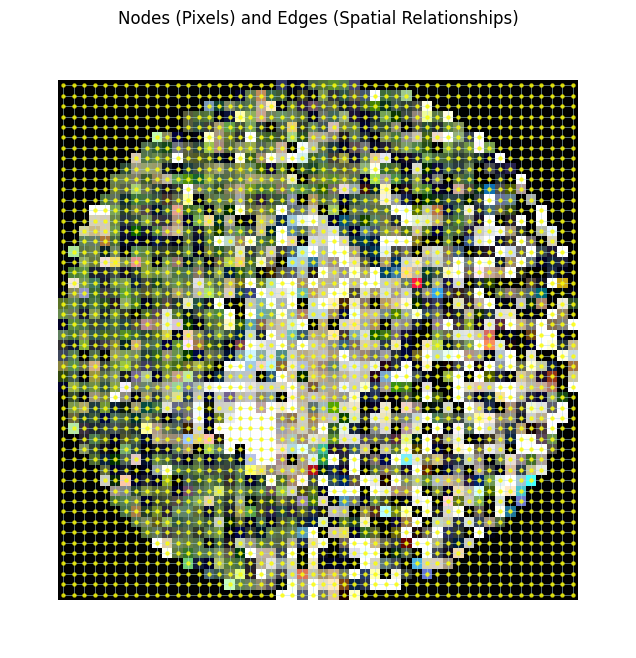

In [34]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title("Nodes (Pixels) and Edges (Spatial Relationships)")

# Draw nodes and edges on top
pos = {(i, j): (j, i) for i, j in G.nodes()}  # flip x and y
nx.draw(G, pos=pos, node_size=5, node_color="yellow", edge_color="lightblue", alpha=0.7, width=0.5)

plt.axis('off')
plt.show()


#Task 4

In [35]:
# Image is 350x350, center location assumed at center
center_x, center_y = resized_img.shape[1] // 2, resized_img.shape[0] // 2

In [36]:
# Build distance map
Y, X = np.meshgrid(np.arange(350), np.arange(350), indexing='ij')
distance_map = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)

In [37]:
# Define masks
forest_mask = np.all(segmented_img == color_palette["Forest"], axis=2)
grass_mask = np.all(segmented_img == color_palette["Grass"], axis=2)

# Circle distances in pixels: 200 ft ≈ 70 pixels, 1000 ft ≈ 175 pixels
within_200_mask = distance_map <= 70
within_1000_mask = (distance_map > 70) & (distance_map <= 175)

# Categorize forest
forest_within_200 = np.logical_and(forest_mask, within_200_mask)
forest_within_1000 = np.logical_and(forest_mask, within_1000_mask)

# Categorize grass
grass_within_200 = np.logical_and(grass_mask, within_200_mask)
grass_within_1000 = np.logical_and(grass_mask, within_1000_mask)

In [38]:
# Helper function to overlay color on a boolean mask
def apply_overlay(image, mask, color_bgr, alpha=0.5):
    overlay = np.zeros_like(image, dtype=np.uint8)
    overlay[:, :] = color_bgr
    return np.where(mask[:, :, None], cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0), image)

# Apply overlays in order
visualization = resized_img.copy()

visualization = apply_overlay(visualization, forest_within_200, (255, 0, 0))        # Blue for forest <200ft
visualization = apply_overlay(visualization, forest_within_1000, (0, 0, 255))       # Red for forest 200–1000ft
visualization = apply_overlay(visualization, grass_within_200, (255, 255, 0))       # Yellow for grass <200ft
visualization = apply_overlay(visualization, grass_within_1000, (0, 165, 255))      # Orange for grass 200–1000ft

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
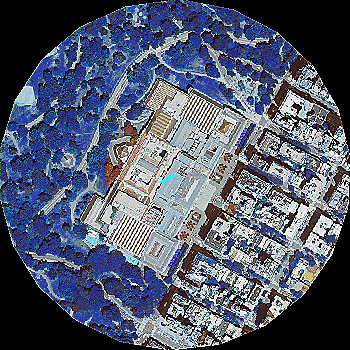

In [39]:
# Get coordinates of all forest pixels
forest_coords = np.column_stack(np.where(forest_mask))

# Compute distance to center
dists = np.linalg.norm(forest_coords - np.array([center_y, center_x]), axis=1)

# Find closest forest pixel
closest_idx = np.argmin(dists)
nearest_y, nearest_x = forest_coords[closest_idx]

# Draw a line (edge) from center to forest
cv2.line(visualization, (center_x, center_y), (nearest_x, nearest_y), (0, 255, 255), 2)

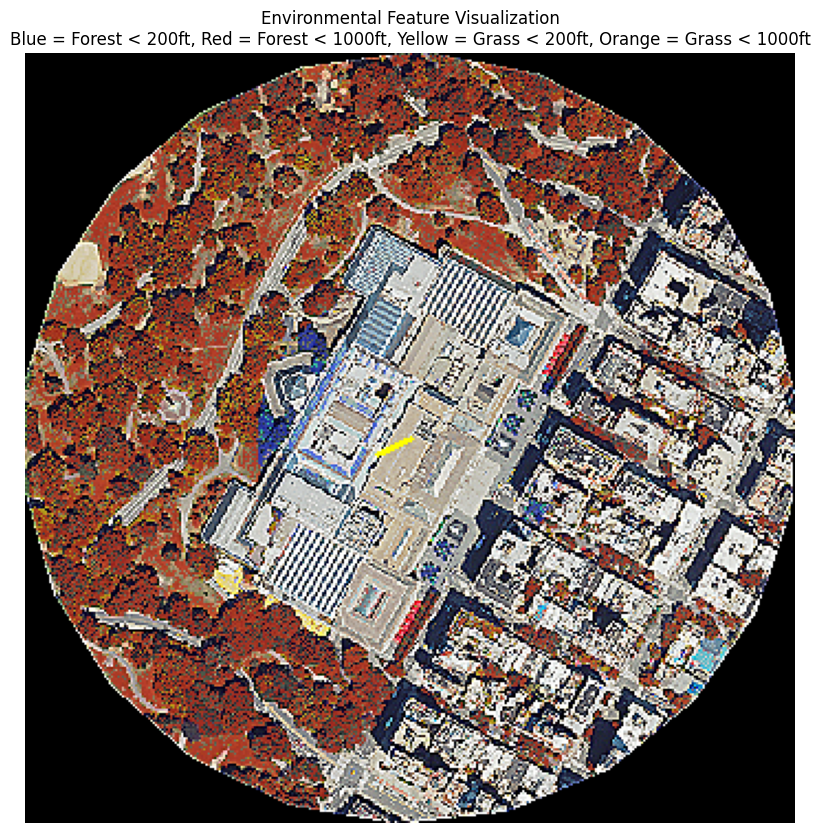

In [40]:
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB))
plt.title("Environmental Feature Visualization\nBlue = Forest < 200ft, Red = Forest < 1000ft, Yellow = Grass < 200ft, Orange = Grass < 1000ft")
plt.axis('off')
plt.show()

#Additional Challenge

In [41]:
# Reuse your existing Sentinel-2 image:
# image = (ee.ImageCollection('COPERNICUS/S2_SR')...

# Check the available bands in the image
available_bands = image.bandNames().getInfo()
print("Available bands:", available_bands)

if 'B8' in available_bands and 'B4' in available_bands and 'B3' in available_bands and 'B11' in available_bands:
    # Compute NDVI (Vegetation Index)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Compute NDWI (Water Index)
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')

    # Urban proxy: high reflectance in SWIR and visible
    urban_index = image.select('B11').add(image.select('B4')).rename('Urban')

    # Add thresholded masks
    forest_mask = ndvi.gt(0.5)
    water_mask = ndwi.gt(0.3)
    urban_mask = urban_index.gt(1000)

    # Add layers to map
    Map.addLayer(ndvi, {'min': 0, 'max': 1, 'palette': ['white', 'green']}, 'NDVI')
    Map.addLayer(ndwi, {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'NDWI')
    Map.addLayer(urban_index, {'min': 500, 'max': 2000, 'palette': ['gray', 'black']}, 'Urban Index')
    Map.addLayer(forest_mask.updateMask(forest_mask), {'palette': ['green']}, 'Detected Forest')
    Map.addLayer(water_mask.updateMask(water_mask), {'palette': ['blue']}, 'Detected Water')
    Map.addLayer(urban_mask.updateMask(urban_mask), {'palette': ['red']}, 'Detected Urban')

else:
    print("The image does not have the necessary bands (B8, B4, B3, B11) to calculate NDVI, NDWI, and Urban Index.")
    print("Please ensure that the 'image' variable contains Sentinel-2 imagery with the required bands.")

Available bands: ['R', 'G', 'B']
The image does not have the necessary bands (B8, B4, B3, B11) to calculate NDVI, NDWI, and Urban Index.
Please ensure that the 'image' variable contains Sentinel-2 imagery with the required bands.


In [42]:
!pip install torchvision segmentation-models-pytorch rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 819.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 23.2 MB/s eta 0:00:00


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

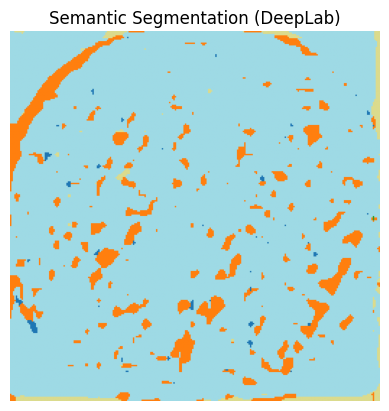

In [43]:
import torch
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp

# Load image
img = Image.open("sharpened_image.png").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

input_tensor = transform(img).unsqueeze(0)

# Load DeepLabV3+ pretrained on Cityscapes or Pascal VOC
model = smp.DeepLabV3Plus(encoder_name="resnet18", encoder_weights="imagenet", classes=21)
model.eval()

# Run prediction
with torch.no_grad():
    output = model(input_tensor)
    prediction = torch.argmax(output.squeeze(), dim=0).numpy()

# Visualize output
import matplotlib.pyplot as plt
plt.imshow(prediction, cmap="tab20")
plt.title("Semantic Segmentation (DeepLab)")
plt.axis("off")
plt.show()

In [44]:
import rasterio
from rasterio.transform import from_origin
import numpy as np

# Example: export the final segmentation_map (numpy array)
transform = from_origin(0, 350, 1, 1)  # top-left x/y and resolution

# Convert string labels back to numerical labels for saving
numerical_segmentation_map = np.zeros_like(segmentation_map, dtype=np.uint8)
numerical_segmentation_map[segmentation_map == "Forest"] = 0
numerical_segmentation_map[segmentation_map == "Grass"] = 1
numerical_segmentation_map[segmentation_map == "Other"] = 2


with rasterio.open(
    'segmentation_map.tif',
    'w',
    driver='GTiff',
    height=numerical_segmentation_map.shape[0],
    width=numerical_segmentation_map.shape[1],
    count=1,
    dtype='uint8',
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(numerical_segmentation_map, 1)

print("Saved: segmentation_map.tif")

Saved: segmentation_map.tif
